In [ ]:
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


## Read and Process Data

In [2]:
'''
def load_blocks
Converts each block of text into a 2D NumPy array (frames × 12 coefficients)

For each block:
- Splits it into lines
- Splits each line by whitespace into numbers
- Converts strings to floats
- Returns each block as a NumPy array of shape (timesteps, 12)
'''

def load_blocks(file_path):
    with open(file_path, 'r') as f:
        raw = f.read().strip()
    blocks = raw.split('\n\n')
    return [np.array([[float(x) for x in line.split()] for line in block.strip().split('\n')])
            for block in blocks]

'''
def load_labels
Converts speaker counts into a list of speaker IDs (1 per block). 
This file is a flat list of speaker IDs, one per block — matching the length of train_blocks.
'''

def load_labels(label_file):
    with open(label_file, 'r') as f:
        counts = list(map(int, f.read().strip().split()))
    labels = []
    for i, count in enumerate(counts):
        labels.extend([i] * count)
    return labels

train_blocks = load_blocks("train.txt")
test_blocks = load_blocks("test.txt")
train_labels = load_labels("train_block_labels.txt")

## Data Exploratory Checks

### Check if the data I have is expected and matches what is expected from the read.me file 

In [3]:
print(f"Total training blocks: {len(train_blocks)}")
print(f"Shape of first block: {train_blocks[0].shape}")
print(f"Labels distribution: {pd.Series(train_labels).value_counts().sort_index()}")


Total training blocks: 370
Shape of first block: (19, 12)
Labels distribution: 0    31
1    35
2    88
3    44
4    29
5    24
6    40
7    50
8    29
Name: count, dtype: int64


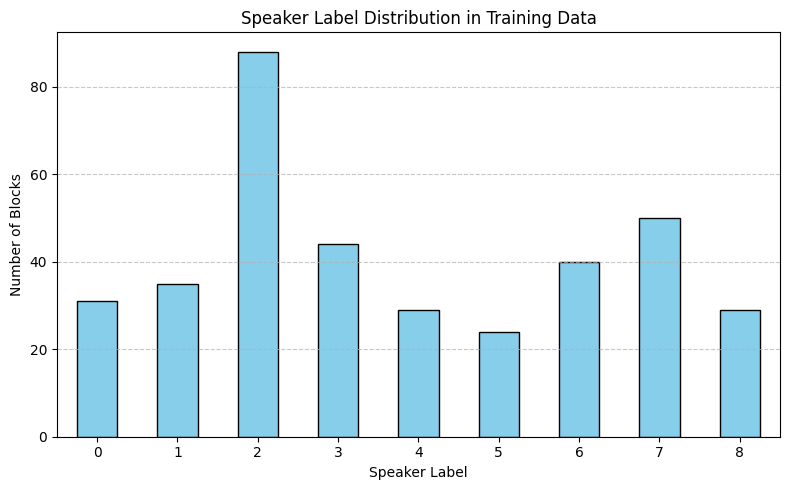

In [4]:
# Visualize class distribution
label_counts = pd.Series(train_labels).value_counts().sort_index()

plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Speaker Label Distribution in Training Data')
plt.xlabel('Speaker Label')
plt.ylabel('Number of Blocks')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### LPC Coefficients over Time
Checking how each LPC coefficient behaves frame by frame for a speaker’s utterance to visually inspect noise, trends, or patterns.

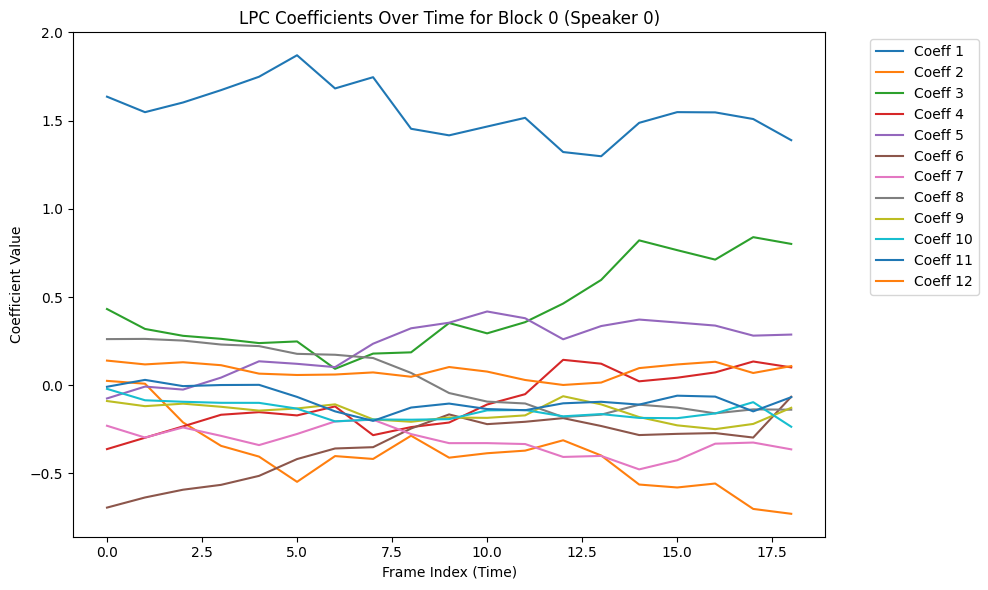

In [5]:
# Choose a block (e.g., block 0)
block_idx = 0
block = train_blocks[block_idx]

plt.figure(figsize=(10, 6))
for i in range(block.shape[1]):  # for each of the 12 LPC coefficients
    plt.plot(block[:, i], label=f'Coeff {i+1}')
plt.title(f"LPC Coefficients Over Time for Block {block_idx} (Speaker {train_labels[block_idx]})")
plt.xlabel("Frame Index (Time)")
plt.ylabel("Coefficient Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Speaker Averages
Checking what an average LPC profile looks like for each speaker to see distinct patterns, the model can easily distinguish them.

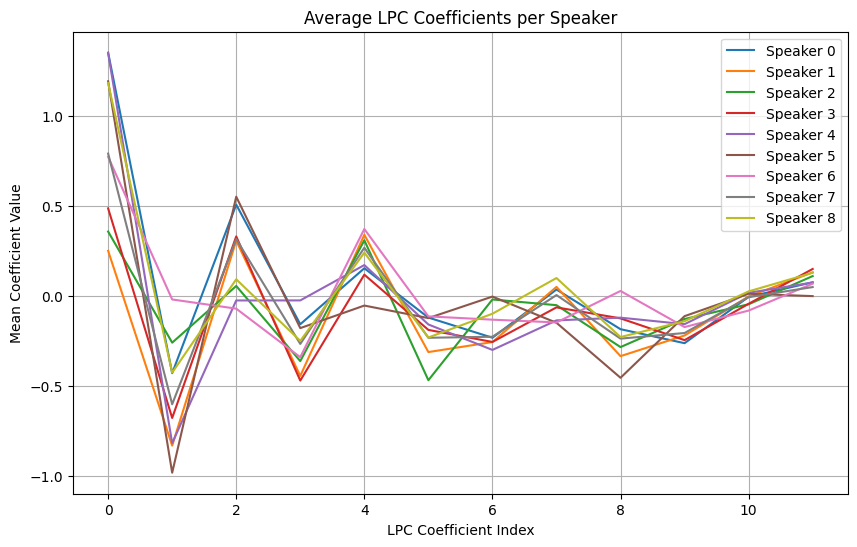

In [6]:
# Average block features per speaker
speaker_means = {i: [] for i in range(9)}
for block, label in zip(train_blocks, train_labels):
    speaker_means[label].append(np.mean(block, axis=0))

# Convert to array and compute average
for speaker in speaker_means:
    speaker_means[speaker] = np.mean(speaker_means[speaker], axis=0)

# Plot
plt.figure(figsize=(10, 6))
for speaker, mean_vector in speaker_means.items():
    plt.plot(mean_vector, label=f"Speaker {speaker}")
plt.title("Average LPC Coefficients per Speaker")
plt.xlabel("LPC Coefficient Index")
plt.ylabel("Mean Coefficient Value")
plt.legend()
plt.grid(True)
plt.show()


### PCA Projection 
Checking whether the blocks will cluster by speaker in a reduced feature space. When we visualize high-dimensional data using a dimensionality reduction technique like PCA, and they are plotted, if the features are informative, then the data points from each speaker will naturally cluster together. Like this:



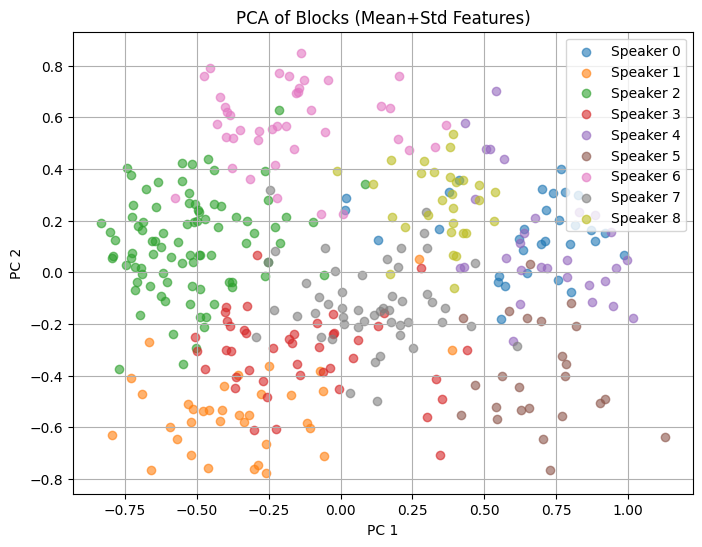

In [7]:
# Flatten each block into a feature vector
X = np.array([np.concatenate([np.mean(b, axis=0), np.std(b, axis=0)]) for b in train_blocks])

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
for speaker in np.unique(train_labels):
    idx = np.array(train_labels) == speaker
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=f"Speaker {speaker}", alpha=0.6)
plt.title("PCA of Blocks (Mean+Std Features)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


### Feature Engineering and Data Prep

In [8]:
'''
This function transforms each variable-length time series block into a fixed-length feature vector. 
Models like logistic regression or random forests expect tabular data not sequences.  ML models need fixed-length input.

Taking the mean and standard deviation of each coefficient captures, what the average speech signature looks like (mean), how much it varies (std)
Concatenating them doubles the features per block (e.g., if 12 LPCs → 24 features).

'''

def extract_features(blocks):
    features = []
    for block in blocks:
        means = np.mean(block, axis=0)
        stds = np.std(block, axis=0)
        features.append(np.concatenate([means, stds]))
    return np.array(features)

X = extract_features(train_blocks)
y = np.array(train_labels)
X_test = extract_features(test_blocks)

'''
Splits the data into 80% for training and 20% for validation. Since we don't have big data I chose the 80/20 split.
stratify=y ensures that each class is equally represented in both sets and random_state=42 ensures reproducibility.
'''

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

'''
Preparing for metrics like getting the AUC score
'''
# Binarize labels
classes = np.unique(y)
y_val_bin = label_binarize(y_val, classes=classes)


### Supervised Models
I'll be trying different Supervised Models and will pick the best model depending on the metrics.
Note that some of the models in the codes below have already been tuned.

In [9]:
supervised_models = {
    "Logistic Regression": LogisticRegression(
        C=0.1, max_iter=1000, multi_class="multinomial", solver="lbfgs", random_state=42),
    "Random Forest": RandomForestClassifier( n_estimators=100,
    max_depth=7,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42),
    "SVM": SVC(kernel="rbf", C=1, gamma="scale", probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
}

In [10]:
'''
Evaluation - Supervised
'''

supervised_results = []
supervised_confusion_matrices = {}

for name, model in supervised_models.items():
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    y_val_pred = pipe.predict(X_val)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_val, y_val_pred)
    gap = train_acc - test_acc

    # AUC Score
    try:
        probs = pipe.predict_proba(X_val)
        auc = roc_auc_score(y_val_bin, probs, multi_class="ovr")
    except:
        auc = np.nan

    cm = confusion_matrix(y_val, y_val_pred)
    supervised_confusion_matrices[name] = cm

    supervised_results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Train-Test Gap": gap,
        "AUC Score": auc
    })

supervised_df = pd.DataFrame(supervised_results).set_index("Model").round(4)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


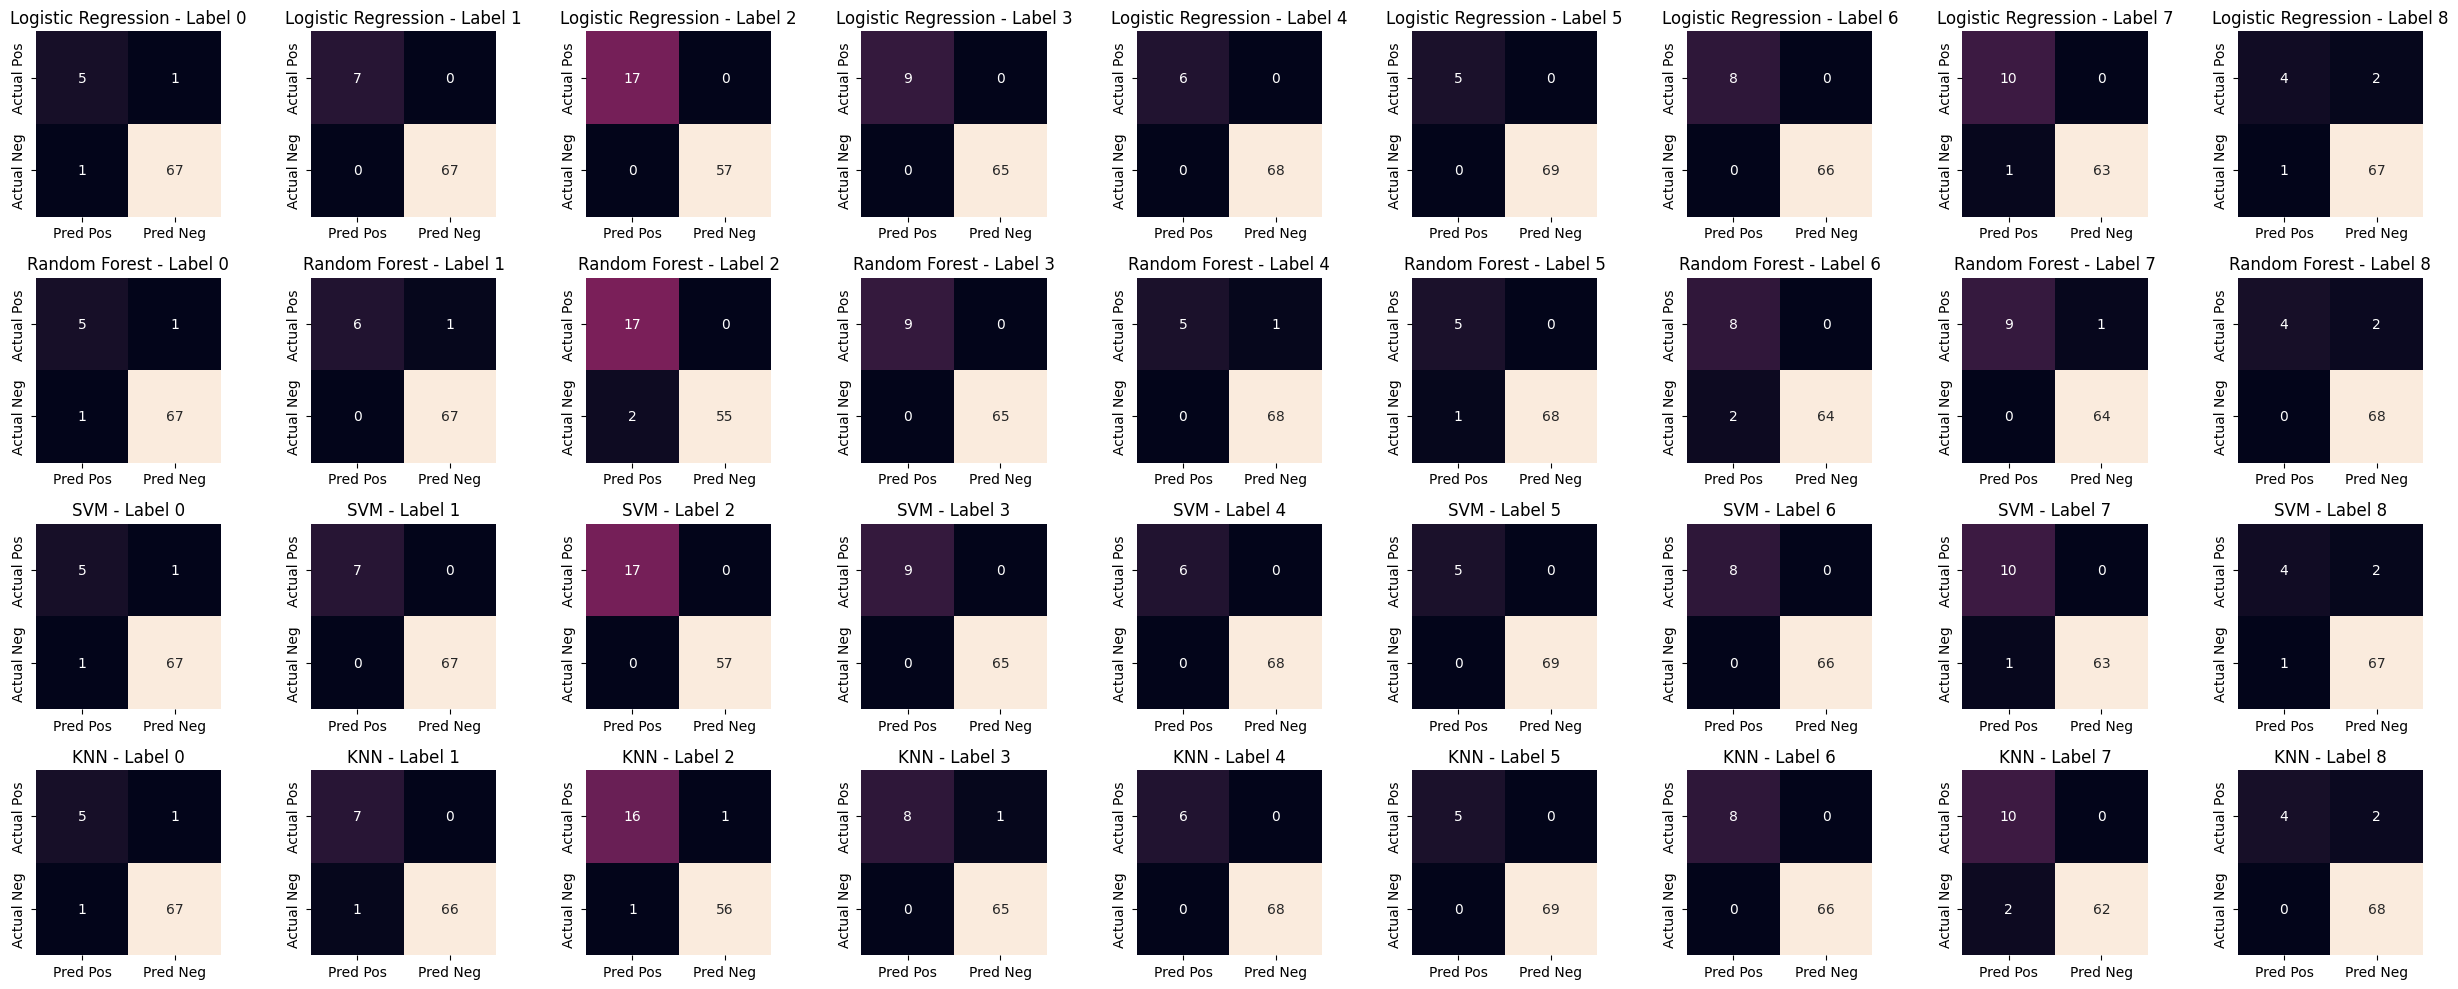

In [11]:
# Plot individual confusion matrices as small 4-box matrices per label
def plot_confusion_matrices(matrices, labels):
    fig, axes = plt.subplots(nrows=len(matrices), ncols=len(labels), figsize=(25, 2.5 * len(matrices)))
    
    if len(matrices) == 1:
        axes = np.expand_dims(axes, axis=0)

    for row_idx, (model_name, cm) in enumerate(matrices.items()):
        for label in range(len(labels)):
            # Binary confusion matrix for class-vs-rest
            tp = cm[label, label]
            fn = cm[label].sum() - tp
            fp = cm[:, label].sum() - tp
            tn = cm.sum() - tp - fn - fp

            binary_cm = np.array([[tp, fn], [fp, tn]])
            ax = axes[row_idx, label]
            sns.heatmap(binary_cm, annot=True, fmt="d", cbar=False, square=True,
                        xticklabels=["Pred Pos", "Pred Neg"],
                        yticklabels=["Actual Pos", "Actual Neg"], ax=ax)
            ax.set_title(f"{model_name} - Label {label}")
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(supervised_confusion_matrices, labels=np.unique(y))

In [18]:
print("\nSupervised Model Comparison:\n")
print(supervised_df)


Supervised Model Comparison:

                     Train Accuracy  Test Accuracy  Train-Test Gap  AUC Score
Model                                                                        
Logistic Regression          0.9865         0.9595          0.0270     0.9977
Random Forest                0.9865         0.9189          0.0676     0.9967
SVM                          0.9966         0.9595          0.0372     0.9984
KNN                          0.9730         0.9324          0.0405     0.9975


### Unsupervised Model

In [13]:
unsupervised_models = {
    "K-Means": KMeans(n_clusters=len(classes), random_state=42),
    "Gaussian Mixture": GaussianMixture(n_components=len(classes), random_state=42)
}


In [14]:
unsupervised_results = []

for name, model in unsupervised_models.items():
    pipe = make_pipeline(StandardScaler(), model)
    model_fit = pipe.fit(X)

    # Automatically get the clustering model from the pipeline
    final_model = [step[1] for step in model_fit.steps if isinstance(step[1], (KMeans, GaussianMixture))][0]

    if hasattr(final_model, "predict"):
        cluster_labels = final_model.predict(X)
    else:
        cluster_labels = final_model.fit_predict(X)

    ami = adjusted_mutual_info_score(y, cluster_labels)
    ari = adjusted_rand_score(y, cluster_labels)

    unsupervised_results.append({
        "Model": name,
        "Adjusted Mutual Info": ami,
        "Adjusted Rand Index": ari
    })

unsupervised_df = pd.DataFrame(unsupervised_results).set_index("Model").round(4)
print("\nUnsupervised Model Comparison:\n")
print(unsupervised_df)



Unsupervised Model Comparison:

                  Adjusted Mutual Info  Adjusted Rand Index
Model                                                      
K-Means                          0.010               0.0020
Gaussian Mixture                 0.327               0.1249


### Exporting the Predictions

In [15]:
# Export test predictions for each model
for name, model in supervised_models.items():
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X, y)  # Fit on full training set

    y_test_pred = pipe.predict(X_test)

    # Format the results
    df_pred = pd.DataFrame({
        "block_num": np.arange(len(y_test_pred)),
        "prediction": y_test_pred
    })

    # Generate a filename-friendly version of the model name
    safe_name = name.lower().replace(" ", "_")

    # Save to CSV
    df_pred.to_csv(f"{safe_name}_predictions.csv", index=False)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### BEST MODEL SELECTION
Logistic Regression is my best model. It has high accuracy, excellent generalization, and near-perfect AUC. Compared to unsupervised models, which struggle to find meaningful clusters, supervised logistic regression clearly outperforms, thanks to having access to true labels during training.

### Logistic Regression: Confusion Matrix
Model correctly classified nearly every sample. Misclassifications occurred only in Class 0 and Class 8, and even then, only 1 or 2 instances.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


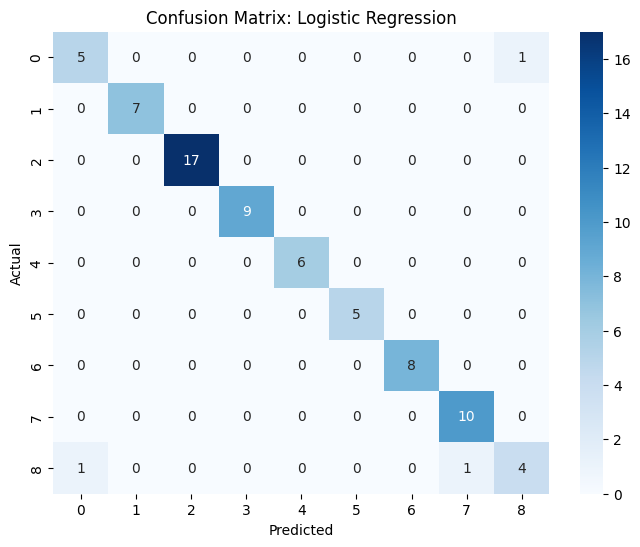

In [ ]:
# Predict on validation set
pipe = make_pipeline(StandardScaler(), LogisticRegression(
    C=0.1, max_iter=1000, multi_class="multinomial", solver="lbfgs", random_state=42))
pipe.fit(X_train, y_train)
y_val_pred = pipe.predict(X_val)

# Plot confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### ROC Curve (Multiclass)
Model almost perfectly classifies all classes, which is rare and impressive. It's not overfitting though (since the test AUC is also near 1.0)
The features (LPC Cepstrum coefficients) carry very strong signal for this speaker classification task.

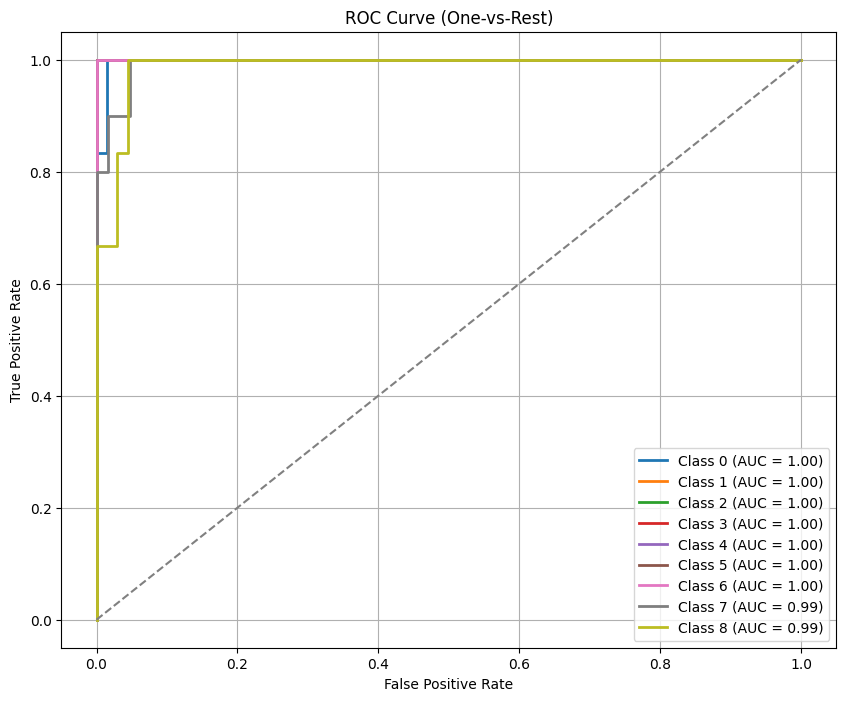

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the validation labels
y_val_bin = label_binarize(y_val, classes=classes)
probs = pipe.predict_proba(X_val)

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


### Additional Findings:
- The dataset does not seem imbalanced except for label 2 had more data.
- The task might be too easy due to clear speaker differences or there might be leak information in the features that I 
might not be familiar of given that this type of data is new to me, and also time limitations.
(e.g., speaker IDs encoded accidentally in features).
- I did an 80/20 split since the dataset is small, but it could still be too small to introduce enough variability especially if each speaker sounds very consistent across their blocks, the model doesn’t have to generalize much.
- There might be insufficient Randomness or Shuffling in the dataset, although I've tried to do import shuffle to randomize the blocks, I still got great/similar results. 


### Extra Visualization:
From the visualization below, most speaker clusters are clearly separated. It is well-separated label 3, 4, 6, 8 which are strong indicators that the features are quite discriminative! Tight groupings suggest consistent intra-speaker features. Within a speaker (say, green/label 2), blocks tend to cluster tightly, which means they’re internally consistent and easier to model.

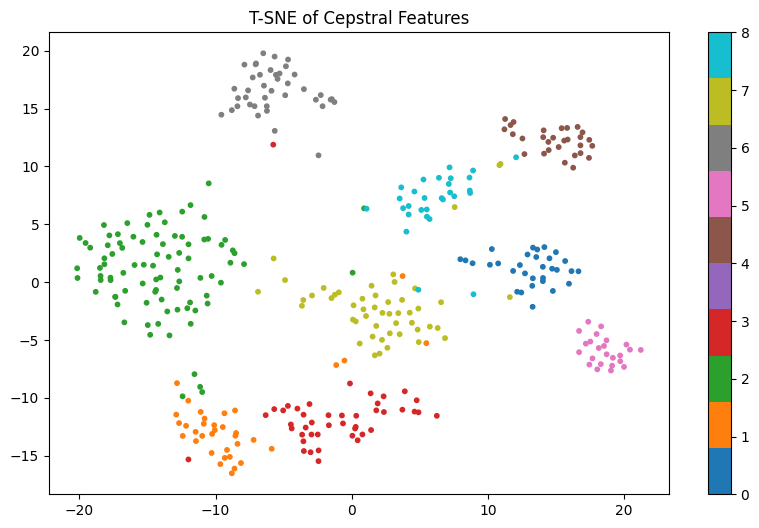

In [ ]:
'''
Extra Analysis:
Tried to use t-SNE to reduce the features into 2D while trying to preserve the local structure of the data.

'''
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(10,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='tab10', s=10)
plt.title("T-SNE of Cepstral Features")
plt.colorbar()
plt.show()
